In [149]:
import pyodbc
import sqlalchemy as sal
from sqlalchemy import create_engine
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [150]:
# Connection parameters
credentials = {
    "host"      : "lhl-data-bootcamp.crzjul5qln0e.ca-central-1.rds.amazonaws.com",
    "port"      : "5432",
    "database"  : "mid_term_project",
    "user"      : "lhl_student",
    "password"  : "lhl_student"
}

In [151]:
link = "postgresql+psycopg2://" + credentials["user"] + ':' + credentials["password"] +\
     '@' + credentials["host"] + ':' + credentials["port"] + '/' + \
     credentials['database']

In [152]:
engine = create_engine(link)

# Task 1: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

In [5]:
query_delay = "SELECT arr_delay, dep_delay FROM flights;"

In [6]:
df_delay = pd.read_sql_query(query_delay, engine)
print(df_delay.shape)
df_delay.head()

(15927485, 2)


,arr_delay,dep_delay
0,-15.0,-6.0
1,-14.0,-3.0
2,41.0,-1.0
3,-25.0,-8.0
4,70.0,66.0


In [8]:
df_delay.isnull().sum()

arr_delay    311744
dep_delay    263754
dtype: int64

In [9]:
df_delay.dropna(axis=0, how='any', inplace=True)

In [10]:
df_delay.shape

(15611152, 2)

In [11]:
#find Q1, Q3, and interquartile range for each column
Q1 = df_delay.quantile(q=.25)
Q3 = df_delay.quantile(q=.75)
IQR = df_delay.apply(stats.iqr)

#only keep rows in dataframe that have values within 1.5*IQR of Q1 and Q3
data_clean = df_delay[~((df_delay < (Q1-1.5*IQR)) | (df_delay > (Q3+1.5*IQR))).any(axis=1)]

#find how many rows are left in the dataframe 
data_clean.shape

(13424478, 2)

## Histogram - Arrival Delay & Mean

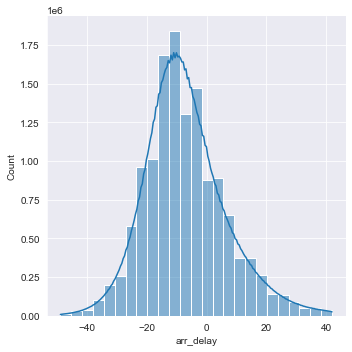

In [13]:
sns.set_style('darkgrid')
sns.displot(data_clean['arr_delay'], bins=25, kde=True)

In [14]:
data_clean['arr_delay'].mean()

-7.190850698254338

## Histogram - Departure Delay & Mean

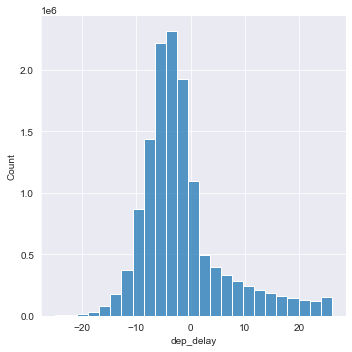

In [50]:
sns.set_style('darkgrid')
sns.displot(data_clean['dep_delay'], bins=25, kde=False)

In [16]:
data_clean['dep_delay'].mean()

-1.555059347558989

# Task 2: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

In [30]:
query_month = "SELECT fl_date, arr_delay, dep_delay FROM flights ORDER BY fl_date;"

In [31]:
df_month = pd.read_sql_query(query_month, engine)

In [33]:
df_month.head()

,fl_date,arr_delay,dep_delay
0,2018-01-01,14.0,-1.0
1,2018-01-01,43.0,53.0
2,2018-01-01,128.0,135.0
3,2018-01-01,3.0,10.0
4,2018-01-01,-32.0,-4.0


In [34]:
type(df_month['fl_date'])

pandas.core.series.Series

In [35]:
pd.to_datetime(df_month.fl_date)

0          2018-01-01
1          2018-01-01
2          2018-01-01
3          2018-01-01
4          2018-01-01
              ...    
15927480   2019-12-31
15927481   2019-12-31
15927482   2019-12-31
15927483   2019-12-31
15927484   2019-12-31
Name: fl_date, Length: 15927485, dtype: datetime64[ns]

In [36]:
df_month['fl_date_month'] = pd.to_datetime(df_month['fl_date']).dt.month

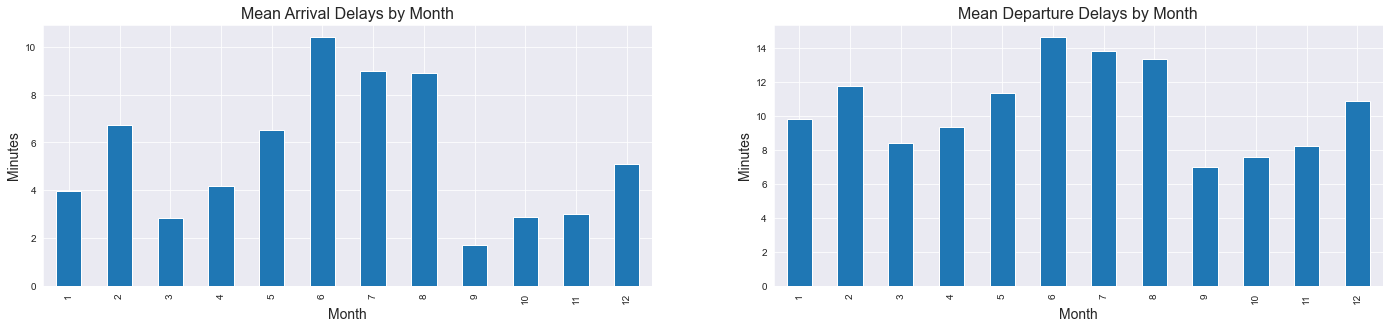

In [49]:
%matplotlib inline

# Arrival and departure delays by month of the year
plt.figure(figsize=(24, 12)).subplots_adjust(hspace = 0.5)

plt.subplot(2, 2 ,1)
df_month.groupby('fl_date_month').arr_delay.mean().plot.bar().set_title('Median Arrival Delays by Month')
plt.title('Mean Arrival Delays by Month', fontsize=16)
plt.ylabel('Minutes', fontsize=14)
plt.xlabel('Month', fontsize=14)

plt.subplot(2, 2 ,2)
df_month.groupby('fl_date_month').dep_delay.mean().plot.bar().set_title('Departure Delays by Month')
plt.title('Mean Departure Delays by Month', fontsize=16)
plt.ylabel('Minutes', fontsize=14)
plt.xlabel('Month', fontsize=14)

plt.show()

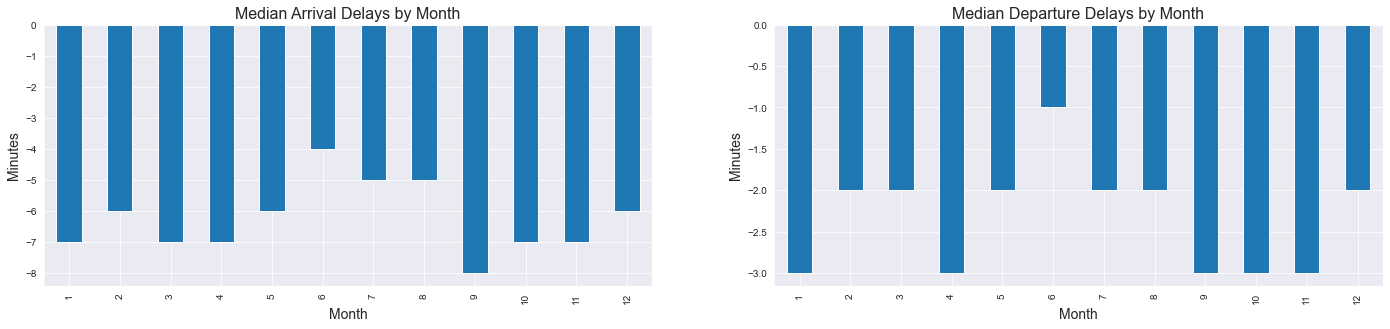

In [48]:
%matplotlib inline

# Arrival and departure delays by month of the year
plt.figure(figsize=(24, 12)).subplots_adjust(hspace = 0.5)

plt.subplot(2, 2 ,1)
df_month.groupby('fl_date_month').arr_delay.median().plot.bar().set_title('Median Arrival Delays by Month')
plt.title('Median Arrival Delays by Month', fontsize=16)
plt.ylabel('Minutes', fontsize=14)
plt.xlabel('Month', fontsize=14)

plt.subplot(2, 2 ,2)
df_month.groupby('fl_date_month').dep_delay.median().plot.bar().set_title('Departure Delays by Month')
plt.title('Median Departure Delays by Month', fontsize=16)
plt.ylabel('Minutes', fontsize=14)
plt.xlabel('Month', fontsize=14)

plt.show()

### The highest median monthly delays are observed in June, July and August. It is probably due to a higher volume of flights and travelers in the summertime.

# Task 4: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

In [63]:
query_taxi_times = "SELECT fl_date, dep_time, taxi_out, arr_time, taxi_in FROM flights WHERE fl_date between '2018-01-01' and '2018-01-07' ORDER BY fl_date ASC;"

df_taxi = pd.read_sql_query(query_taxi_times, engine)
print(df_taxi.shape)
df_taxi.head()

(133859, 5)


,fl_date,dep_time,taxi_out,arr_time,taxi_in
0,2018-01-01,1726.0,15.0,1859.0,9.0
1,2018-01-01,1005.0,15.0,1140.0,10.0
2,2018-01-01,623.0,17.0,815.0,5.0
3,2018-01-01,1907.0,10.0,2105.0,7.0
4,2018-01-01,2304.0,11.0,551.0,6.0


In [88]:
df_taxi.sort_values(['fl_date', 'dep_time'], ascending = [True, True], inplace=True)
df_taxi.tail()

,fl_date,dep_time,taxi_out,arr_time,taxi_in
122056,2018-01-07,2359.0,21.0,212.0,9.0
127522,2018-01-07,2359.0,17.0,731.0,3.0
118373,2018-01-07,2400.0,10.0,732.0,7.0
119723,2018-01-07,2400.0,70.0,105.0,12.0
125329,2018-01-07,2400.0,26.0,800.0,6.0


In [101]:
df_taxi['taxi_out'].mean()

17.277717598368433

In [69]:
df_taxi['taxi_in'].mean()

7.874435039855371

In [113]:
# Plotting dataframes
df_taxi_out = df_taxi.iloc[:, 1:3]
df_taxi_in = df_taxi.iloc[:, 3:5]

In [112]:
# Remove Outliers
df_taxi_out = df_taxi_out.drop(df_taxi_out[(df_taxi_out['taxi_out']>400)].index)
df_taxi_in = df_taxi_in.drop(df_taxi_in[(df_taxi_in['taxi_in']>400)].index)

## Plotting Taxi Times Based on Departure and Arrival Delays

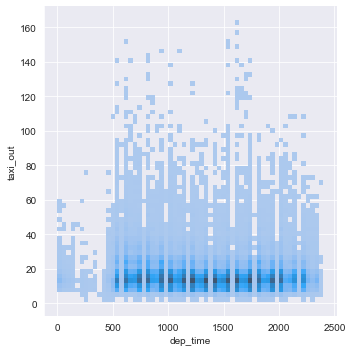

In [111]:
sns.displot(x="dep_time", y="taxi_out", data=df_taxi_out[['dep_time','taxi_out']], kind="hist", bins=60)

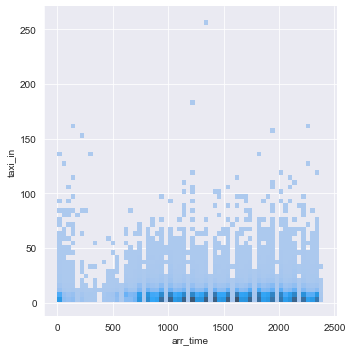

In [114]:
sns.displot(x="arr_time", y="taxi_in", data=df_taxi_in[['arr_time','taxi_in']], kind="hist", bins=60)

### By observing the graphs of taxi times based on hourly arrival and departure times, we can infer that higher traffic leads to higher taxi times. Typically, taxiing in an airplane takes a lot less time than taxiing out because departing flights can be delayed whereas landing a plane cannot be delayed. The longest taxi times are observed in the daytime when traffic is at its peak.

# Task 5: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

Out of all the arrivals that are late (arr_delay > 0), what percentage of those were late at departure (dep_delay > 0).
All of the late arrival, figure out what percentage of those departed late.

Take all late departures and see if air time is less than (arrival time - departure time)

In [153]:
query_eta = "SELECT fl_date, dep_time, dep_delay, arr_time, arr_delay, air_time FROM flights ORDER BY fl_date ASC;"

df_eta = pd.read_sql_query(query_eta, engine)
print(df_eta.shape)
df_eta.head()

(15927485, 6)


,fl_date,dep_time,dep_delay,arr_time,arr_delay,air_time
0,2018-01-01,2241.0,236.0,145.0,215.0,113.0
1,2018-01-01,1857.0,52.0,38.0,47.0,206.0
2,2018-01-01,557.0,-3.0,833.0,21.0,229.0
3,2018-01-01,1604.0,44.0,1746.0,31.0,87.0
4,2018-01-01,520.0,-7.0,605.0,-10.0,30.0


In [154]:
# Filter for Arrival Delay < 0
df_eta = df_eta.drop(df_eta[(df_eta['arr_delay']<0)].index)
df_eta.shape

(6085845, 6)

In [155]:
# Filter for Departure Delay < 0
df_eta = df_eta.drop(df_eta[(df_eta['dep_delay']<0)].index)
df_eta.shape

(4518591, 6)

In [156]:
4518591/6085845*100

74.24755313354186

In [157]:
df_eta.head()

,fl_date,dep_time,dep_delay,arr_time,arr_delay,air_time
0,2018-01-01,2241.0,236.0,145.0,215.0,113.0
1,2018-01-01,1857.0,52.0,38.0,47.0,206.0
3,2018-01-01,1604.0,44.0,1746.0,31.0,87.0
7,2018-01-01,1651.0,66.0,1806.0,50.0,61.0
10,2018-01-01,1658.0,36.0,1755.0,35.0,41.0


### There was a total of 6085845 late arrivals in the database and 4518591 late arrivals out of the 6085485 were also delay at the moment of departure. The percentage of delays that is already created before departure is 74.25%.

In [158]:
# Input new column to check if airlines can lower the delay during flights
df_eta['lower_delay'] = df_eta.apply(lambda row: row.arr_delay - 
                                  row.dep_delay, axis = 1)
df_eta.head()

,fl_date,dep_time,dep_delay,arr_time,arr_delay,air_time,lower_delay
0,2018-01-01,2241.0,236.0,145.0,215.0,113.0,-21.0
1,2018-01-01,1857.0,52.0,38.0,47.0,206.0,-5.0
3,2018-01-01,1604.0,44.0,1746.0,31.0,87.0,-13.0
7,2018-01-01,1651.0,66.0,1806.0,50.0,61.0,-16.0
10,2018-01-01,1658.0,36.0,1755.0,35.0,41.0,-1.0


In [159]:
df_eta.shape

(4518591, 7)

In [161]:
df_eta[df_eta.lower_delay < 0].shape[0]

2425367

In [162]:
2425367/4518591*100

53.67529391352305

### Out of the 4518591 flights that experienced a late departure, 2425367 flights had a lower arrival delay. We can therefore assume that airlines are able to reduce delays 53.68% of the time while flying.